In [55]:
#Copyright 2018, Seokjun Bu, Softcomputing LAB all rights reserved.
from keras import backend as K
from keras.utils import np_utils
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.convolutional import Convolution3D, MaxPooling3D, UpSampling3D, AveragePooling3D
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D, AveragePooling2D
from keras.layers import LSTM, TimeDistributed
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model
from keras.models import load_model
from keras.metrics import top_k_categorical_accuracy
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import itertools
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers
%matplotlib inline

In [38]:
X_train = np.load('exam/X_train.npy')
X_test = np.load('exam/X_test.npy')
Y_train = np.load('exam/Y_train.npy')
Y_test = np.load('exam/Y_test.npy')

In [39]:
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(3000, 64, 64, 3) (1000, 64, 64, 3) (3000, 3) (1000, 3)


In [62]:
class_list = np.array(['young','middle','old'])

['middle']


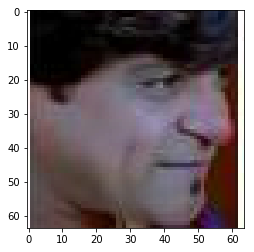

In [63]:
random_idx = np.random.randint(0,X_train.shape[0],1)
random_img = X_train[random_idx][0]
random_img_label = class_list[np.argmax(Y_train[random_idx],axis=1)]
print(random_img_label)
plt.imshow(random_img[:,:,:])
plt.show()

In [76]:
model_input = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
model_hidden = Convolution2D(16, kernel_size=(2, 2), padding='same', activation='relu')(model_input)
model_hidden = Convolution2D(16, kernel_size=(2, 2), padding='same', activation='relu')(model_hidden)
model_hidden = MaxPooling2D((2, 2))(model_hidden)
model_hidden = BatchNormalization()(model_hidden)
model_hidden = Convolution2D(16, kernel_size=(2, 2), padding='same', activation='relu')(model_hidden)
model_hidden = Convolution2D(16, kernel_size=(2, 2), padding='same', activation='relu')(model_hidden)
model_hidden = MaxPooling2D((2, 2))(model_hidden)
model_hidden = BatchNormalization()(model_hidden)
model_hidden = Dropout(0.5)(model_hidden)
model_hidden = Flatten()(model_hidden)
model_hidden = Dense(512, activation='relu')(model_hidden)
model_output = Dense(Y_train.shape[1], activation='softmax')(model_hidden)
model_cnn = Model(model_input, model_output)
model_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 64, 64, 16)        208       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 64, 64, 16)        1040      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 32, 16)        1040      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 32, 32, 16)        1040      
__________

In [77]:
es = EarlyStopping(mode='auto',monitor='val_loss',patience=3)

In [78]:
#my_sgd = optimizers.SGD(lr=0.1, momentum=0.0, decay=0.0, nesterov = False)
model_cnn.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

In [79]:
model_history = model_cnn.fit(X_train,Y_train,\
                              validation_data=(X_test,Y_test),\
                              epochs=10,batch_size=500,verbose=2,\
                              shuffle=True,callbacks=[es])

Train on 3000 samples, validate on 1000 samples
Epoch 1/10
 - 26s - loss: 5.7380 - acc: 0.4637 - val_loss: 6.2275 - val_acc: 0.4550
Epoch 2/10
 - 24s - loss: 4.0280 - acc: 0.5313 - val_loss: 2.7934 - val_acc: 0.5900
Epoch 3/10
 - 24s - loss: 2.9475 - acc: 0.5690 - val_loss: 2.9476 - val_acc: 0.6020
Epoch 4/10
 - 24s - loss: 2.6828 - acc: 0.6253 - val_loss: 2.4892 - val_acc: 0.5910
Epoch 5/10
 - 24s - loss: 2.4749 - acc: 0.6367 - val_loss: 2.2180 - val_acc: 0.6330
Epoch 6/10
 - 25s - loss: 2.3318 - acc: 0.6727 - val_loss: 2.2551 - val_acc: 0.6050
Epoch 7/10
 - 25s - loss: 2.2652 - acc: 0.6750 - val_loss: 2.2024 - val_acc: 0.6140
Epoch 8/10
 - 25s - loss: 2.2185 - acc: 0.6930 - val_loss: 2.1165 - val_acc: 0.6700
Epoch 9/10
 - 24s - loss: 2.1598 - acc: 0.7080 - val_loss: 2.0852 - val_acc: 0.6960
Epoch 10/10
 - 24s - loss: 2.0870 - acc: 0.7303 - val_loss: 2.0288 - val_acc: 0.6850


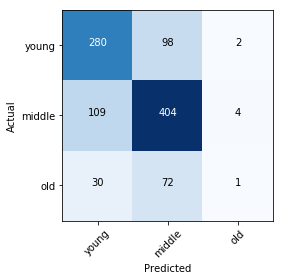

In [81]:
def plot_confusion_matrix(model_input, feature, label, class_info):
    pred = model_input.predict(feature)
    cnf_matrix = confusion_matrix(np.argmax(label, axis=1), np.argmax(pred, axis=1))
    plt.figure()
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    tick_marks = np.arange(len(class_info))
    plt.xticks(tick_marks, class_info, rotation=45), plt.yticks(tick_marks, class_info)
    thresh = cnf_matrix.max()/2.
    for i in range(cnf_matrix.shape[0]):
        for j in range(cnf_matrix.shape[1]):
            plt.text(j, i, cnf_matrix[i, j], horizontalalignment='center', color='white' if cnf_matrix[i,j]>thresh else 'black')
    plt.ylabel('Actual'), plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()
plot_confusion_matrix(model_cnn, X_test, Y_test, class_list)

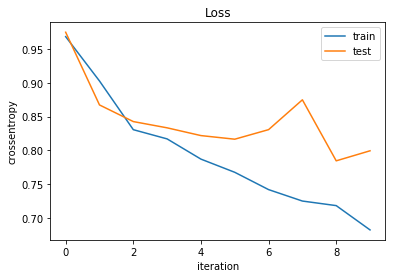

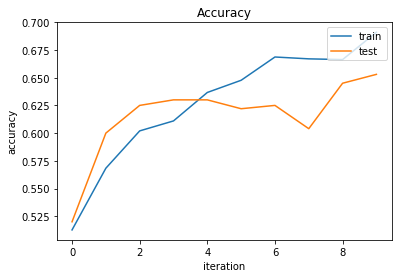

In [70]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Loss')
plt.xlabel('iteration'), plt.ylabel('crossentropy')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
# Accuracy
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('Accuracy')
plt.xlabel('iteration'), plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper right')
plt.show()